In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns 
import pickle
import numpy as np
import os
from constants import *

In [58]:
def plot_results(df, model_name):
    """
    Given a dataframe with results of the model, plot accuracy and loss of epochs 
    
    """
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(15, 5)
    fig.suptitle(model_name)
    df.plot(y=['train acc', 'val acc'], ax=axes[0])
    axes[0].set_title('Accuracy')
    axes[1].set_title('Loss')
    best_train_acc = df['train acc'].max()
    best_train_acc_epoch = df['train acc'].idxmax(0)
    best_test_acc = df['val acc'].max()
    best_test_acc_epoch = df['val acc'].idxmax(0)
    best_train_loss = df['train loss'].min()
    best_train_loss_epoch = df['train loss'].idxmin(0)
    best_test_loss = df['val loss'].min()
    best_test_loss_epoch = df['val loss'].idxmin(0)
    axes[0].set_xlabel('Best train acc: {:.2f} on epoch {}\nBest test acc: {:.2f} on epoch {}'
                       .format(best_train_acc, best_train_acc_epoch, best_test_acc, best_test_acc_epoch))
    axes[1].set_xlabel('Best train loss: {:.2f} on epoch {}\nBest test loss: {:.2f} on epoch {}'
                   .format(best_train_loss, best_train_loss_epoch, best_test_loss, best_test_loss_epoch))
    df.plot(y=['train loss', 'val loss'], ax=axes[1])

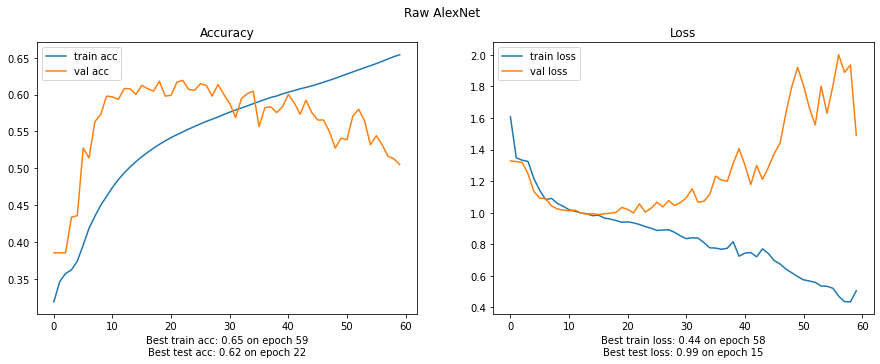

In [59]:
df = pd.read_csv('first_result.csv', delimiter=';')
df = df.head(60)
plot_results(df, 'Raw AlexNet')

In [28]:
df = pd.read_csv('results.csv', delimiter=';')

In [29]:
emotion_results = df.loc[df['task']=='emotion']
emotion_results = emotion_results.drop('task', axis=1)
emotion_results

result subset    metric  epoch
0    0.400896  train  accuracy      1
1    0.420913  train  accuracy      2
2    0.431224  train  accuracy      3
3    0.451218  train  accuracy      4
4    0.467357  train  accuracy      5
..        ...    ...       ...    ...
395  0.030812   test      loss     96
396  0.021270   test      loss     97
397  0.032410   test      loss     98
398  0.035414   test      loss     99
399  0.044773   test      loss    100

[400 rows x 4 columns]

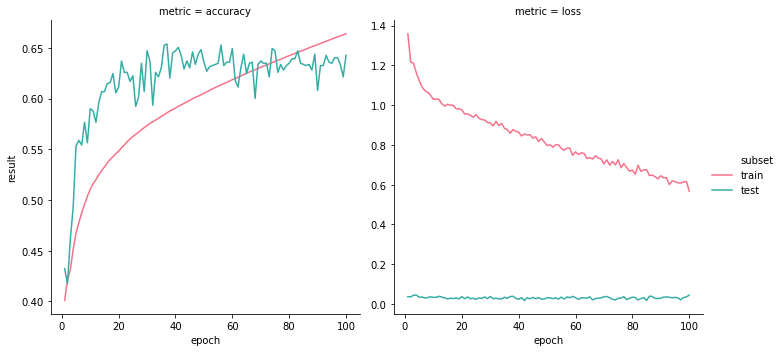

In [61]:
sns.relplot(x='epoch', y='result', hue='subset', size=None, style=None, 
            data=emotion_results, col='metric', palette='husl',
            kind='line', height=5, aspect=1, 
            facet_kws={
                'sharey': False
            })

In [44]:
accuracies = df.loc[df['metric']=='accuracy']

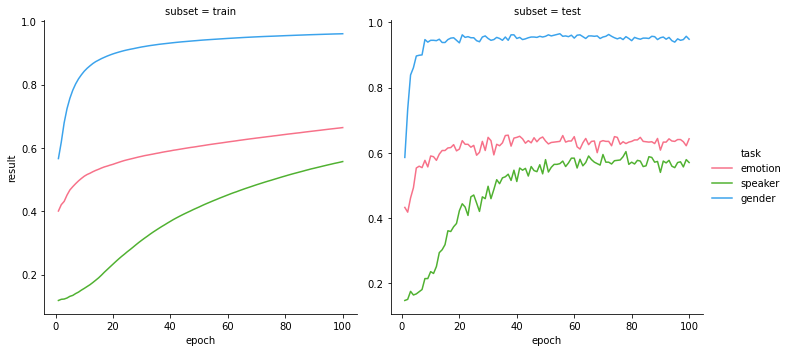

In [56]:
plot = sns.relplot(x='epoch', y='result', hue='task', size=None, style=None, 
            data=accuracies, col='subset', palette='husl',
            kind='line', height=5, aspect=1, 
            facet_kws={
                'sharey': False
            })

In [71]:
accuracies.loc[(accuracies['subset'] == 'test') & (accuracies['task'] == 'emotion')]['result'].max()

0.6539753639417694

In [2]:
with open('models\\best_models\\AlexNet--IEMOCAP-4_four_prep-false_224_train_augmentation-false.md', 'rb') as f:
    net = pickle.load(f)

In [3]:
net.history

[{'batches': [{'train_loss': 1.3928837776184082, 'train_batch_size': 32},
   {'train_loss': 1.3224446773529053, 'train_batch_size': 32},
   {'train_loss': 1.3556450605392456, 'train_batch_size': 32},
   {'train_loss': 1.2758052349090576, 'train_batch_size': 32},
   {'train_loss': 1.342820644378662, 'train_batch_size': 32},
   {'train_loss': 1.3217570781707764, 'train_batch_size': 32},
   {'train_loss': 1.38785982131958, 'train_batch_size': 32},
   {'train_loss': 1.3131400346755981, 'train_batch_size': 32},
   {'train_loss': 1.2559845447540283, 'train_batch_size': 32},
   {'train_loss': 1.2713325023651123, 'train_batch_size': 32},
   {'train_loss': 1.3454009294509888, 'train_batch_size': 32},
   {'train_loss': 1.305867075920105, 'train_batch_size': 32},
   {'train_loss': 1.2265952825546265, 'train_batch_size': 32},
   {'train_loss': 1.366341233253479, 'train_batch_size': 32},
   {'train_loss': 1.2310360670089722, 'train_batch_size': 32},
   {'train_loss': 1.1454861164093018, 'train_batc

In [2]:
def create_results_df(net):
    dfs_list = []
    for metric in ['acc', 'loss']:
        _dfs_list = []
        for subset in ['train', 'valid']:
            results = net.history[:, f'{subset}_{metric}']
            df = pd.DataFrame(results, columns=['result'])
            df['epochs'] = np.arange(1, len(results) + 1)
            df['subset'] = subset
            _dfs_list.append(df)
        df = pd.concat(_dfs_list, ignore_index=True)
        df['metric'] = metric
        dfs_list.append(df)
    final_df = pd.concat(dfs_list, ignore_index=True)
    return final_df

In [19]:
create_results_df(net, 'AlexNet--IEMOCAP-4_four_prep-false_224_train_augmentation-false')

In [3]:
def create_results_summary():
    dfs_list = []
    models_list = [file for file in os.listdir(RESULTS_FOLDER) if file.endswith('md') and 'IEMOCAP' in file]
    path_to_processed_list = os.path.join(RESULTS_FOLDER, 'processed_list.temp')
    if os.path.exists(path_to_processed_list):
        with open(path_to_processed_list, 'rb') as f:
            processed_list = pickle.load(f)
            files_list = processed_list['files']
            dfs_list = processed_list['dfs']
    else:
        processed_list = {}
        dfs_list = []
        files_list = []
    for file in models_list:
        print(file)
        if file in files_list:
            continue
        model, dataset = file[:-3].split('--')
        dataset, _, preprocessing, _, _, augmentation = dataset.split('_')
        preprocessing = preprocessing.split('-')[-1]
        augmentation = augmentation.split('-')[-1]
        with open('models\\best_models\\AlexNet--IEMOCAP-4_four_prep-false_224_train_augmentation-false.md', 'rb') as f:
            net = pickle.load(f)
        df = create_results_df(net)
        df['model'] = model
        df['dataset'] = dataset
        df['preprocessing'] = preprocessing
        df['augmentation'] = augmentation
        dfs_list.append(df)
        files_list.append(file)
        processed_list['dfs'] = dfs_list
        processed_list['files'] = files_list
        with open(path_to_processed_list, 'wb') as f:
            pickle.dump(processed_list, f)
        print('///Done///')
    if len(files_list) == files:
        final_df = pd.concat(dfs_list, ignore_index=True)
        final_df.to_csv(os.path.join(RESULTS_FOLDER, 'iemocap_all_results.csv'), sep = ';', index=False)

In [4]:
create_results_summary()

AlexNet--IEMOCAP-4_four_prep-false_224_train_augmentation-false.md
AlexNet--IEMOCAP-4_four_prep-false_224_train_augmentation-true.md
///Done///
AlexNet--IEMOCAP-4_four_prep-true_224_train_augmentation-false.md


RuntimeError: CUDA out of memory. Tried to allocate 196.00 MiB (GPU 0; 2.00 GiB total capacity; 1.19 GiB already allocated; 165.23 MiB free; 1.21 GiB reserved in total by PyTorch)